# Mixture density network for regression tasks

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib.pyplot as plt
from util import get_data4mdn
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded")

Packages loaded


Generate data for training mixture density network

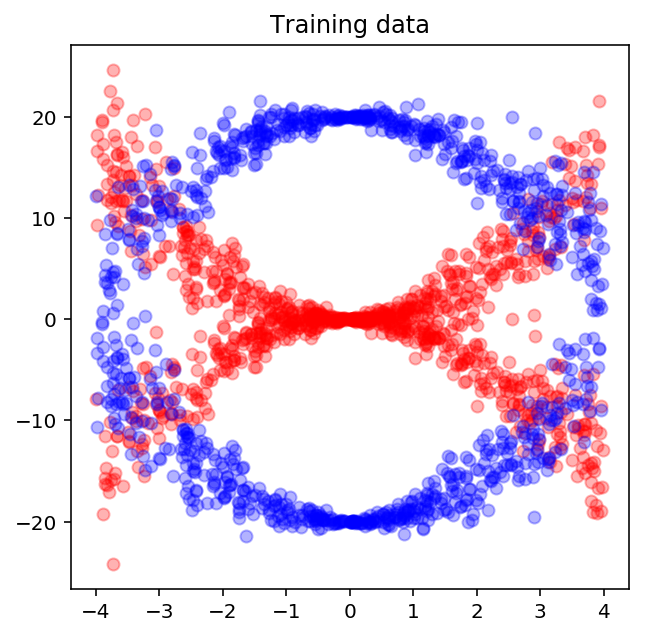

In [2]:
""" Get Data """
xdata,_ydata,_zdata = get_data4mdn(_xmin=-4.,_xmax=4.,_bias=20,_nsample=1e3)
ydata = np.concatenate((_ydata,_zdata),axis=1)
""" Plot """
plt.figure(figsize=(5,5))
plt.plot(xdata,ydata[:,0],'ro',alpha=0.3)
plt.plot(xdata,ydata[:,1],'bo',alpha=0.3)
plt.title('Training data')
plt.show()

Mixture Density Network Class

In [3]:
class basic_mdn(object):
    def __init__(self,_name='',_xdim=1,_ydim=1,_hdim=64,_actv=tf.nn.relu):
        self.name = _name
        self.xdim = _xdim
        self.ydim = _ydim
        self.hdim = _hdim
        self.actv = _actv
        """ Build model """
        self.build_model()
        
        """ Print """
        print ("[%s] instantiated" %(self.name))
        print (" xdim:[%d],ydim:[%d]"%(self.xdim,self.ydim))
        print ("Global Variables")
        for i in range(len(self.g_vars)):
            w_name  = self.g_vars[i].name
            w_shape = self.g_vars[i].get_shape().as_list()
            print (" [%d] Name:[%s] Shape:[%s]" % (i,w_name,w_shape))
        
    """
        Build model
    """
    def build_model(self):
        self.x  = tf.placeholder(dtype=tf.float32,shape=[None,self.xdim])
        self.y  = tf.placeholder(dtype=tf.float32,shape=[None,self.ydim])
        self.kp = tf.placeholder(dtype=tf.float32,shape=[])
        self.is_training = tf.placeholder(dtype=tf.bool,shape=[])
        
        self.fully_init  = tf.random_normal_initializer(stddev=0.01)
        self.bias_init   = tf.constant_initializer(0.)
        self.bn_init     = {'beta': tf.constant_initializer(0.),
                           'gamma': tf.random_normal_initializer(1., 0.02)}
        self.bn_params   = {'is_training':self.is_training,'decay':0.9,'epsilon':1e-5,
                           'param_initializers':self.bn_init,'updates_collections': None}
        with tf.variable_scope('W',reuse=False) as scope:
            with slim.arg_scope([slim.fully_connected],
                                activation_fn=self.actv,
                                weights_initializer=self.fully_init,
                                biases_initializer=self.bias_init,
                                normalizer_fn=slim.batch_norm,
                                normalizer_params=self.bn_params):
                _net = slim.fully_connected(self.x,self.hdim,scope='lin0')
                """ NOTE: Always dropout! modify keep probability """
                _net = slim.dropout(_net,keep_prob=self.kp,is_training=True,scope='dr0')  
                _net = slim.fully_connected(_net,self.hdim,scope='lin1')
                _net = slim.dropout(_net,keep_prob=self.kp,is_training=True,scope='dr1')  
                """ Mixture Density Network """
                _pi_hat = slim.fully_connected(_net,self.hdim,scope='pi_hat')
                
                
        """ Get variables """
        _g_vars = tf.global_variables()
        self.g_vars = [var for var in _g_vars if 'W/' in var.name]
    
print ("Class ready")        

Class ready


Instantiate MDN Class

In [4]:
M = basic_mdn(_name='MDN',_xdim=1,_ydim=2)

[MDN] instantiated
 xdim:[1],ydim:[2]
Global Variables
 [0] Name:[W/lin0/weights:0] Shape:[[1, 64]]
 [1] Name:[W/lin0/BatchNorm/beta:0] Shape:[[64]]
 [2] Name:[W/lin0/BatchNorm/moving_mean:0] Shape:[[64]]
 [3] Name:[W/lin0/BatchNorm/moving_variance:0] Shape:[[64]]
 [4] Name:[W/lin1/weights:0] Shape:[[64, 64]]
 [5] Name:[W/lin1/BatchNorm/beta:0] Shape:[[64]]
 [6] Name:[W/lin1/BatchNorm/moving_mean:0] Shape:[[64]]
 [7] Name:[W/lin1/BatchNorm/moving_variance:0] Shape:[[64]]
 [8] Name:[W/pi_hat/weights:0] Shape:[[64, 64]]
 [9] Name:[W/pi_hat/BatchNorm/beta:0] Shape:[[64]]
 [10] Name:[W/pi_hat/BatchNorm/moving_mean:0] Shape:[[64]]
 [11] Name:[W/pi_hat/BatchNorm/moving_variance:0] Shape:[[64]]
